In [1]:
import os
import shutil


## MIAS .pgm to .jpg conversion

In [ ]:
# import os
# from PIL import Image

# def convert_pgm_to_jpg(source_dir, dest_dir):
#     os.makedirs(dest_dir, exist_ok=True)
#     for root, _, files in os.walk(source_dir):
#         for file in files:
#             if file.lower().endswith('.pgm'):
#                 pgm_path = os.path.join(root, file)
#                 jpg_path = os.path.join(dest_dir, os.path.splitext(file)[0] + '.jpg')
#                 with Image.open(pgm_path) as img:
#                     img = img.convert('RGB')  # Convert to RGB mode
#                     img.save(jpg_path, 'JPEG')
#     print(f"Conversion completed. JPG files are saved in {dest_dir}")

# # Example usage
# source_pgm_dir = "/home/hamza/Desktop/MIAS/Malignant"
# dest_jpg_dir = "/home/hamza/Desktop/MIAS/malignant"
# convert_pgm_to_jpg(source_pgm_dir, dest_jpg_dir)

Conversion completed. JPG files are saved in /home/hamza/Desktop/MIAS/malignant


In [ ]:

# Base directories
source_base = '/home/hamza/Desktop/RMI DATA/sets'
dest_base = '/home/hamza/Desktop/RMI DATA/flattened_jpg'

# Target categories
categories = ['Benign', 'Malignant', 'Normal']

# Create destination folders
for category in categories:
    os.makedirs(os.path.join(dest_base, category), exist_ok=True)

def collect_images():
    for root, _, files in os.walk(source_base):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                # Identify class and source subfolder
                path_parts = root.split(os.sep)
                class_name = None
                subfolder = path_parts[-1]  # Assumes last folder is like B4, M1, etc.

                # Determine class based on path
                if any('benign' in p.lower() for p in path_parts):
                    class_name = 'Benign'
                elif any('malignant' in p.lower() for p in path_parts):
                    class_name = 'Malignant'
                elif any('normal' in p.lower() for p in path_parts):
                    class_name = 'Normal'
                else:
                    continue  # Skip unknown categories

                # Construct new filename: e.g., B4-image1.jpg
                name_prefix = subfolder
                new_filename = f"{name_prefix}-{file}"

                # Ensure unique filename
                dest_dir = os.path.join(dest_base, class_name)
                name, ext = os.path.splitext(new_filename)
                counter = 1
                final_filename = new_filename
                while os.path.exists(os.path.join(dest_dir, final_filename)):
                    final_filename = f"{name}_{counter}{ext}"
                    counter += 1

                src_path = os.path.join(root, file)
                dest_path = os.path.join(dest_dir, final_filename)
                shutil.copy(src_path, dest_path)

collect_images()
print("Images transferred and renamed with subfolder prefix.")


Images transferred and renamed with subfolder prefix.


In [3]:
# Cell 1: Import Required Libraries
import os
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from sklearn.model_selection import train_test_split
import shutil


2025-04-17 03:05:36.376937: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744841136.494873    4292 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744841136.527769    4292 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-17 03:05:36.863959: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
import os
# Cell 2: Define Paths
benign_dir = "/home/hamza/Desktop/RMI DATA/flattened_jpg/Benign"
malignant_dir = "/home/hamza/Desktop/RMI DATA/flattened_jpg/Malignant"
augment_output_dir_b = "/home/hamza/Desktop/RMI DATA/augmented_jpg/Benign"
augment_output_dir_m = "/home/hamza/Desktop/RMI DATA/augmented_jpg/Malignant"
os.makedirs(augment_output_dir_b, exist_ok=True)
os.makedirs(augment_output_dir_m, exist_ok=True)


In [6]:
# Cell 3: Get images that start with specific prefixes and have valid image extensions
image_files_b = [f for f in os.listdir(benign_dir) if f.startswith(('B','N','m')) and f.lower().endswith(('.jpg', '.jpeg', '.png'))]
image_files_m = [f for f in os.listdir(malignant_dir) if f.startswith(('P','m')) and f.lower().endswith(('.jpg', '.jpeg', '.png'))]


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import os
import numpy as np
import random

# Initialize random seeds
random.seed(42)
np.random.seed(42)

# Enhanced Data Generator

datagen = ImageDataGenerator(
    rotation_range=10,             # Small rotations to simulate patient positioning variance
    width_shift_range=0.05,        # Mild shift (no heavy displacement)
    height_shift_range=0.05,
    shear_range=0.05,              # Very light shear to simulate compression
    zoom_range=0.1,                # Slight zoom, avoids cutting off edges
    horizontal_flip=True,          # Useful because left/right breast symmetry is okay
    vertical_flip=False,           # Not realistic in clinical settings
    brightness_range=[0.9, 1.1],   # Slight changes only
    fill_mode='nearest'            # Avoids artifacts at borders
)


# Initialize counter
augmented_count = 0
target_count = 100

# Calculate how many augmentations per original image
aug_per_image = max(1, target_count // len(image_files_b))

# Modified augmentation loop
for img_name in image_files_b:
    if augmented_count >= target_count:
        break
        
    img_path = os.path.join(benign_dir, img_name)
    img = load_img(img_path)
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)  # Add batch dimension
    
    # Generate unique prefix
    prefix = os.path.splitext(img_name)[0] + f'_{random.randint(1000,9999)}'
    
    # Configure flow
    gen = datagen.flow(
        x,
        batch_size=1,
        save_to_dir=augment_output_dir_b,
        save_prefix=prefix,
        save_format='jpg',
        shuffle=True,
        seed=random.randint(1, 1000)
    )
    
    # Generate augmentations for this image
    for _ in range(aug_per_image):
        if augmented_count >= target_count:
            break
        next(gen)
        augmented_count += 1
    
    del gen

# Handle remainder if target_count isn't divisible by aug_per_image
remaining = target_count - augmented_count
if remaining > 0:
    # Distribute remaining augmentations across random images
    for img_name in random.sample(image_files_b, remaining):
        img_path = os.path.join(malignant_dir, img_name)
        img = load_img(img_path)
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        
        prefix = os.path.splitext(img_name)[0] + f'_{random.randint(1000,9999)}'
        gen = datagen.flow(
            x,
            batch_size=1,
            save_to_dir=augment_output_dir_b,
            save_prefix=prefix,
            save_format='jpg',
            shuffle=True,
            seed=random.randint(1, 1000)
        )
        next(gen)
        augmented_count += 1
        del gen

print(f"Generated {augmented_count} augmented images")

Generated 100 augmented images


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import os
import numpy as np
import random

# Initialize random seeds
random.seed(42)
np.random.seed(42)

# Enhanced Data Generator

datagen = ImageDataGenerator(
    rotation_range=10,             # Small rotations to simulate patient positioning variance
    width_shift_range=0.05,        # Mild shift (no heavy displacement)
    height_shift_range=0.05,
    shear_range=0.05,              # Very light shear to simulate compression
    zoom_range=0.1,                # Slight zoom, avoids cutting off edges
    horizontal_flip=True,          # Useful because left/right breast symmetry is okay
    vertical_flip=False,           # Not realistic in clinical settings
    brightness_range=[0.9, 1.1],   # Slight changes only
    fill_mode='nearest'            # Avoids artifacts at borders
)


# Initialize counter
augmented_count = 0
target_count = 100

# Calculate how many augmentations per original image
aug_per_image = max(1, target_count // len(image_files_m))

# Modified augmentation loop
for img_name in image_files_m:
    if augmented_count >= target_count:
        break
        
    img_path = os.path.join(malignant_dir, img_name)
    img = load_img(img_path)
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)  # Add batch dimension
    
    # Generate unique prefix
    prefix = os.path.splitext(img_name)[0] + f'_{random.randint(1000,9999)}'
    
    # Configure flow
    gen = datagen.flow(
        x,
        batch_size=1,
        save_to_dir=augment_output_dir_m,
        save_prefix=prefix,
        save_format='jpg',
        shuffle=True,
        seed=random.randint(1, 1000)
    )
    
    # Generate augmentations for this image
    for _ in range(aug_per_image):
        if augmented_count >= target_count:
            break
        next(gen)
        augmented_count += 1
    
    del gen

# Handle remainder if target_count isn't divisible by aug_per_image
remaining = target_count - augmented_count
if remaining > 0:
    # Distribute remaining augmentations across random images
    for img_name in random.sample(image_files_m, remaining):
        img_path = os.path.join(malignant_dir, img_name)
        img = load_img(img_path)
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        
        prefix = os.path.splitext(img_name)[0] + f'_{random.randint(1000,9999)}'
        gen = datagen.flow(
            x,
            batch_size=1,
            save_to_dir=augment_output_dir_m,
            save_prefix=prefix,
            save_format='jpg',
            shuffle=True,
            seed=random.randint(1, 1000)
        )
        next(gen)
        augmented_count += 1
        del gen

print(f"Generated {augmented_count} augmented images")

Generated 100 augmented images


In [ ]:
# # Cell 6: Combine benign original + augmented into a final folder
# import shutil

# final_benign_dir = "/home/hamza/Desktop/RMI DATA/final_dataset/Benign"
# final_malignant_dir = "/home/hamza/Desktop/RMI DATA/final_dataset/Malignant"

# os.makedirs(final_benign_dir, exist_ok=True)
# os.makedirs(final_malignant_dir, exist_ok=True)

# # Copy original benign
# for f in os.listdir(benign_dir):
#     if f.lower().endswith(('.jpg', '.jpeg', '.png', 'pgm')):
#         shutil.copy(os.path.join(benign_dir, f), final_benign_dir)

# # Copy augmented malignant
# for f in os.listdir(augment_output_dir):
#     shutil.copy(os.path.join(augment_output_dir, f), final_malignant_dir)

# # Copy malignant
# for f in os.listdir(malignant_dir):
#     if f.lower().endswith(('.jpg', '.jpeg', '.png', 'pgm')):
#         shutil.copy(os.path.join(malignant_dir, f), final_malignant_dir)


In [9]:
# Cell 6: Combine benign original + augmented into a final folder
import shutil

final_benign_dir = "/home/hamza/Desktop/RMI DATA/final_dataset_jpg/Benign"
final_malignant_dir = "/home/hamza/Desktop/RMI DATA/final_dataset_jpg/Malignant"

os.makedirs(final_benign_dir, exist_ok=True)
os.makedirs(final_malignant_dir, exist_ok=True)

# Copy original benign
for f in os.listdir(benign_dir):
    if f.lower().endswith(('.jpg', '.jpeg', '.png')):
        shutil.copy(os.path.join(benign_dir, f), final_benign_dir)

# Copy augmented benign
for f in os.listdir(augment_output_dir_b):
    shutil.copy(os.path.join(augment_output_dir_b, f), final_benign_dir)

# Copy malignant
for f in os.listdir(malignant_dir):
    if f.lower().endswith(('.jpg', '.jpeg', '.png')):
        shutil.copy(os.path.join(malignant_dir, f), final_malignant_dir)

# Copy augmented malignant
for f in os.listdir(augment_output_dir_m):
    shutil.copy(os.path.join(augment_output_dir_m, f), final_malignant_dir)


In [ ]:
# # Cell 7: Split dataset for train, val, test using folders
# from sklearn.model_selection import train_test_split

# def split_data_to_subfolders(source_dir, dest_base_dir, class_name, test_size=0.1, val_size=0.1):
#     image_paths = [os.path.join(source_dir, f) for f in os.listdir(source_dir)
#                    if f.lower().endswith(('.jpg', '.jpeg', '.png','.pgm'))]

#     train_val, test = train_test_split(image_paths, test_size=test_size, random_state=42)
#     train, val = train_test_split(train_val, test_size=val_size / (1 - test_size), random_state=42)

#     def copy_to(subset_name, paths):
#         dest_dir = os.path.join(dest_base_dir, subset_name, class_name)
#         os.makedirs(dest_dir, exist_ok=True)
#         for path in paths:
#             shutil.copy(path, dest_dir)

#     copy_to("train", train)
#     copy_to("val", val)
#     copy_to("test", test)

# # Output split dir
# split_base_dir = "/home/hamza/Desktop/RMI DATA/split_dataset"

# # For both classes
# split_data_to_subfolders(final_benign_dir, split_base_dir, "Benign")
# split_data_to_subfolders(final_malignant_dir, split_base_dir, "Malignant")


In [27]:
# Cell 7: Split dataset for train, val, test using folders
from sklearn.model_selection import train_test_split

def split_data_to_subfolders(source_dir, dest_base_dir, class_name, test_size=0.1, val_size=0.1):
    image_paths = [os.path.join(source_dir, f) for f in os.listdir(source_dir)
                   if f.lower().endswith(('.jpg', '.jpeg', '.png',))]

    train_val, test = train_test_split(image_paths, test_size=test_size, random_state=42)
    train, val = train_test_split(train_val, test_size=val_size / (1 - test_size), random_state=42)

    def copy_to(subset_name, paths):
        dest_dir = os.path.join(dest_base_dir, subset_name, class_name)
        os.makedirs(dest_dir, exist_ok=True)
        for path in paths:
            shutil.copy(path, dest_dir)

    copy_to("train", train)
    copy_to("val", val)
    copy_to("test", test)

# Output split dir
split_base_dir = "/home/hamza/Desktop/RMI DATA/split_dataset_jpg"

# For both classes
split_data_to_subfolders(final_benign_dir, split_base_dir, "Benign")
split_data_to_subfolders(final_malignant_dir, split_base_dir, "Malignant")

In [1]:
split_base_dir = "/home/hamza/Desktop/RMI DATA/split_dataset_jpg"

In [26]:
from tensorflow.keras.backend import clear_session

# Clear TensorFlow session
clear_session()
print("TensorFlow session cleared.")

TensorFlow session cleared.


In [27]:
import gc

gc.collect()

0

In [6]:
# Cell 8: Define image generators for train, val, and test

import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (224, 224)
batch_size = 32

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255,    rotation_range=10,             # Small rotations to simulate patient positioning variance
    width_shift_range=0.05,        # Mild shift (no heavy displacement)
    height_shift_range=0.05,
    shear_range=0.05,              # Very light shear to simulate compression
    zoom_range=0.1,                # Slight zoom, avoids cutting off edges
    horizontal_flip=True,          # Useful because left/right breast symmetry is okay
    vertical_flip=False,           # Not realistic in clinical settings
    brightness_range=[0.9, 1.1],   # Slight changes only
    fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    os.path.join(split_base_dir, "train"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',  # To enable categorical class labels
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    os.path.join(split_base_dir, "val"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',  # To enable categorical class labels
    shuffle=False
)

test_gen = test_datagen.flow_from_directory(
    os.path.join(split_base_dir, "test"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',  # To enable categorical class labels
    shuffle=False
)




Found 616 images belonging to 2 classes.
Found 78 images belonging to 2 classes.
Found 78 images belonging to 2 classes.


In [28]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load the model (update the path to your file)
model = load_model("/home/hamza/Downloads/public_dataset_colab_using_class_weights.h5")


In [29]:
# Compile the model
initial_learning_rate = 0.00001
model.compile(
    optimizer=Adam(learning_rate=initial_learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)


In [30]:
# You already defined train_gen and val_gen

# You can dynamically get steps per epoch like this (optional):
steps_per_epoch = train_gen.samples // train_gen.batch_size
validation_steps = val_gen.samples // val_gen.batch_size

# Training
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,  # or simply 150 if fixed
    epochs=50,
    validation_data=val_gen,
    validation_steps=validation_steps,
    callbacks=[early_stopping]
)


Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.5565 - loss: 3.3601 - val_accuracy: 0.6094 - val_loss: 2.7994
Epoch 2/50
 1/19 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 0.6875 - loss: 3.1961

/home/hamza/miniconda3/envs/tf/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6875 - loss: 3.1961 - val_accuracy: 0.6094 - val_loss: 2.7833
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 296ms/step - accuracy: 0.6537 - loss: 2.8877 - val_accuracy: 0.7188 - val_loss: 2.6299
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5000 - loss: 3.2252 - val_accuracy: 0.7188 - val_loss: 2.6284
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 290ms/step - accuracy: 0.6424 - loss: 2.6930 - val_accuracy: 0.6875 - val_loss: 2.5728
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5312 - loss: 2.9693 - val_accuracy: 0.6875 - val_loss: 2.5697
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 304ms/step - accuracy: 0.6265 - loss: 2.6304 - val_accuracy: 0.6562 - val_loss: 2.5489
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6562 - loss: 2.6248 - val_accuracy: 0.6719 - val_loss: 2.5491
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 287ms/step - accuracy: 0.6531 - loss: 2.6262 - val_accuracy: 0.6719 - val_loss

In [31]:
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']
overall_train_loss     = np.mean(train_loss)
overall_train_accuracy = np.mean(train_accuracy)
overall_val_loss       = np.mean(val_loss)
overall_val_accuracy   = np.mean(val_accuracy)

# Print the overall accuracy
print("Overall Training Accuracy:", overall_train_accuracy)
print("Overall Validation Accuracy:", overall_val_accuracy)


Overall Training Accuracy: 0.7333192133903503
Overall Validation Accuracy: 0.7384375


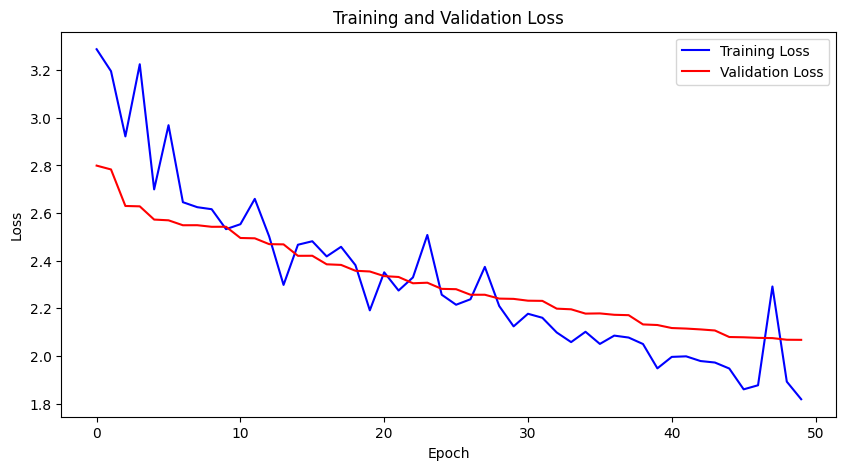

In [32]:

plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss',   color='blue')
plt.plot(val_loss,   label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


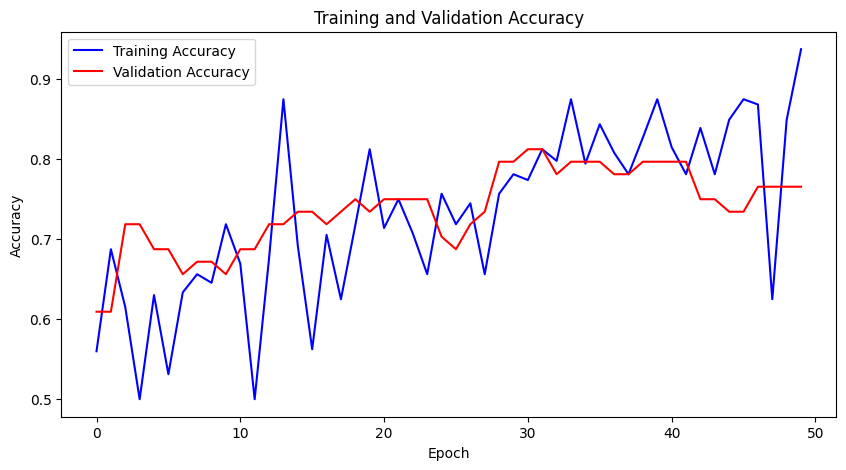

In [34]:

plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Training Accuracy',   color='blue')
plt.plot(val_accuracy,   label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [35]:
# Evaluate
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 904ms/step - accuracy: 0.7588 - loss: 2.1027
Test Accuracy: 0.7051, Test Loss: 2.1750


In [37]:
model.save("/home/hamza/Downloads/final_model_using_claass_weights.h5")

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
Classification Report:
              precision    recall  f1-score   support

      Benign       0.65      0.87      0.75        39
   Malignant       0.81      0.54      0.65        39

    accuracy                           0.71        78
   macro avg       0.73      0.71      0.70        78
weighted avg       0.73      0.71      0.70        78



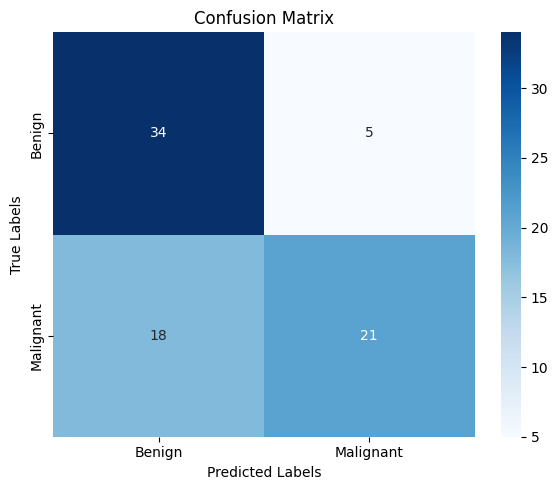

In [36]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Predict the test set
Y_pred = model.predict(test_gen, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)

# Step 2: Get true labels
y_true = test_gen.classes

# Step 3: Class labels
class_labels = list(test_gen.class_indices.keys())

# Step 4: Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Step 5: Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 6: Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [11]:
from tensorflow.keras.backend import clear_session

# Clear TensorFlow session
clear_session()
print("TensorFlow session cleared.")

TensorFlow session cleared.


In [12]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load the model (update the path to your file)
model = load_model("/home/hamza/Desktop/final files/public_dataset_colab.h5")

# Compile the model
initial_learning_rate = 0.00001
model.compile(
    optimizer=Adam(learning_rate=initial_learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)


1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x758ad079ff60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step
Classification Report:
              precision    recall  f1-score   support

      Benign       0.50      0.85      0.63        39
   Malignant       0.50      0.15      0.24        39

    accuracy                           0.50        78
   macro avg       0.50      0.50      0.43        78
weighted avg       0.50      0.50      0.43        78



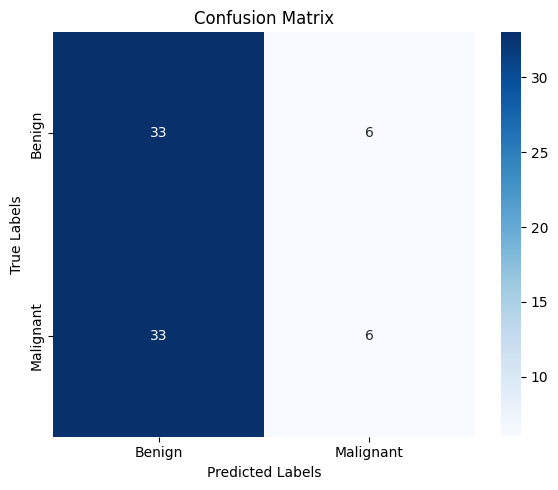

In [13]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Predict the test set
Y_pred = model.predict(test_gen, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)

# Step 2: Get true labels
y_true = test_gen.classes

# Step 3: Class labels
class_labels = list(test_gen.class_indices.keys())

# Step 4: Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Step 5: Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 6: Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
